# **Two of Four: Electric Vehicle Charging Patterns**
I chose the second dataset because my friend Sebastián, who knows a lot about batteries, told me that not all lithium-ion batteries are the same — they actually use different technologies. This sparked my curiosity to explore how much these different technologies affect a battery’s performance.

In [27]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/BBDD/ev_charging_patterns.csv"
import pandas as pd
df = pd.read_csv(path)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Fix all column names by stripping spaces and special characters
df_cleaned.columns = df_cleaned.columns.str.strip()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

In [30]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values in critical columns
critical_cols = ['Battery Capacity (kWh)', 'Vehicle Age (years)', 'Energy Consumed (kWh)',
                 'Distance Driven (since last charge) (km)', 'Charging Duration (hours)',
                 'State of Charge (Start %)', 'State of Charge (End %)', 'Charging Rate (kW)',
                 'Temperature (°C)']
df_cleaned = df.dropna(subset=critical_cols)

# Reset index after drop
df_cleaned.reset_index(drop=True, inplace=True)

# Show remaining missing values
print("Missing values after cleaning:")
print(df_cleaned.isnull().sum())

# Basic statistical summary
print(df_cleaned[critical_cols].describe())

User ID                                      0
Vehicle Model                                0
Battery Capacity (kWh)                       0
Charging Station ID                          0
Charging Station Location                    0
Charging Start Time                          0
Charging End Time                            0
Energy Consumed (kWh)                       66
Charging Duration (hours)                    0
Charging Rate (kW)                          66
Charging Cost (USD)                          0
Time of Day                                  0
Day of Week                                  0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (km)    66
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
User Type                                    0
dtype: int64
Missing values after cleaning:
User ID         

In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1131 non-null   object 
 1   Vehicle Model                             1131 non-null   object 
 2   Battery Capacity (kWh)                    1131 non-null   float64
 3   Charging Station ID                       1131 non-null   object 
 4   Charging Station Location                 1131 non-null   object 
 5   Charging Start Time                       1131 non-null   object 
 6   Charging End Time                         1131 non-null   object 
 7   Energy Consumed (kWh)                     1131 non-null   float64
 8   Charging Duration (hours)                 1131 non-null   float64
 9   Charging Rate (kW)                        1131 non-null   float64
 10  Charging Cost (USD)                 

The dataset includes several variables worth evaluating. Battery Capacity (kWh) ranges from 1.5 to 193, which is a wide range—values below the 1st percentile may need filtering due to suspiciously low entries. Vehicle Age (years) spans from 0 to almost 12 years and appears reasonable. Energy Consumed (kWh) has very low minimum values (as low as 0.045), which could be normal for short charging sessions. Charging Duration (hours) goes up to 7.6 hours, which could be an outlier but not an extreme one. Distance Driven (km) ranges from 0 to nearly 400 km, which seems typical. However, State of Charge (%) includes unrealistic values above 100% (e.g., Start max = 125.87%, End max = 177.70%) and should be filtered out. Charging Rate (kW) reaches up to 97 kW, which is feasible for fast charging. Lastly, Temperature (°C) ranges from -10°C to 73°C, and extremely high values should be reviewed as potential data errors.

In [32]:
# Filter out unrealistic State of Charge values
df_cleaned = df_cleaned[
    (df_cleaned['State of Charge (Start %)'] <= 100) &
    (df_cleaned['State of Charge (End %)'] <= 100)
]

# Optionally filter out extremely low battery capacities (<5 kWh)
df_cleaned = df_cleaned[df_cleaned['Battery Capacity (kWh)'] > 5]

# Create binary target based on battery capacity percentiles
threshold = df_cleaned['Battery Capacity (kWh)'].quantile(0.25)
df_cleaned['Battery_Condition'] = df_cleaned['Battery Capacity (kWh)'].apply(
    lambda x: 0 if x < threshold else 1
)

# Show how many examples per class
print(df_cleaned['Battery_Condition'].value_counts())



Battery_Condition
1    857
0    247
Name: count, dtype: int64


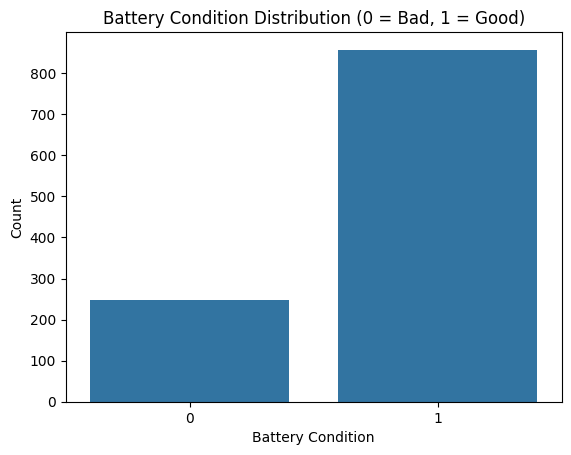

In [33]:
# Plot target class distribution
sns.countplot(data=df_cleaned, x='Battery_Condition')
plt.title('Battery Condition Distribution (0 = Bad, 1 = Good)')
plt.xlabel('Battery Condition')
plt.ylabel('Count')
plt.show()

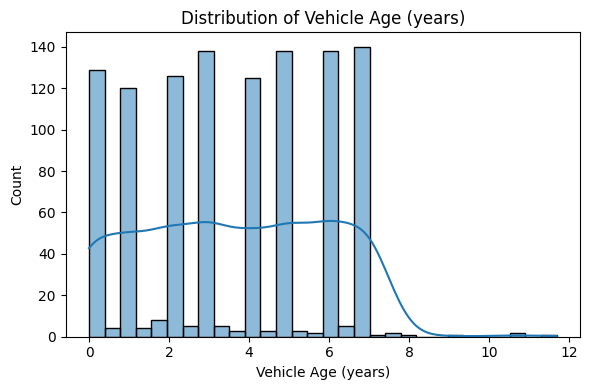

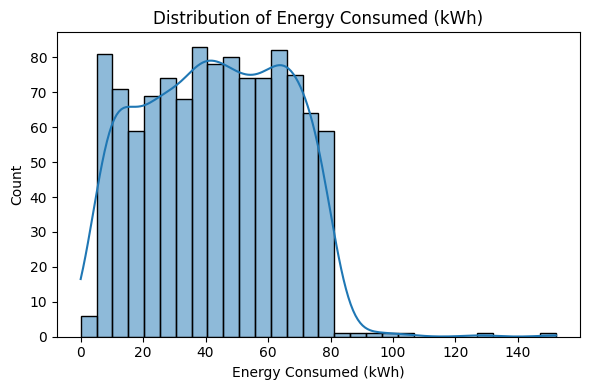

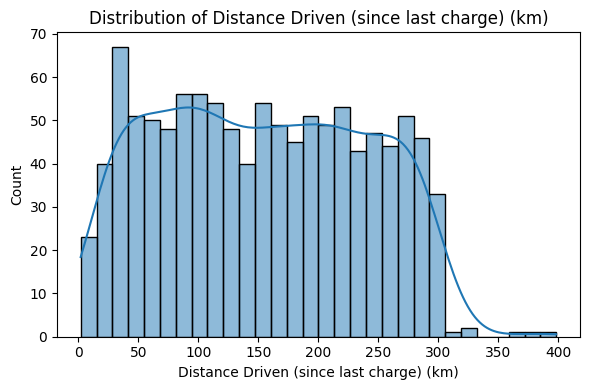

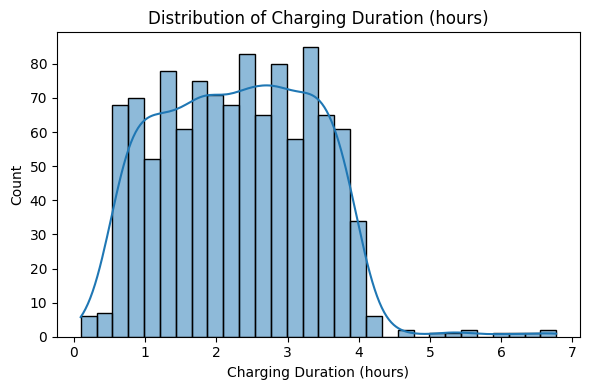

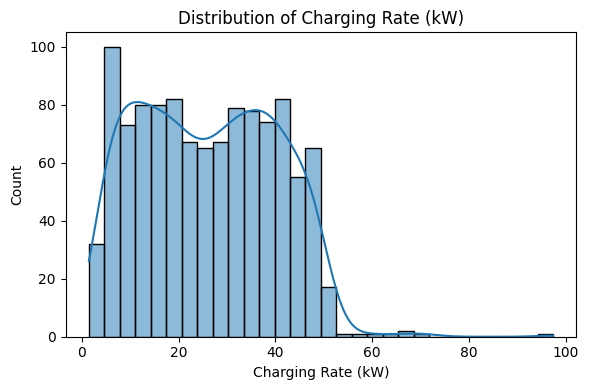

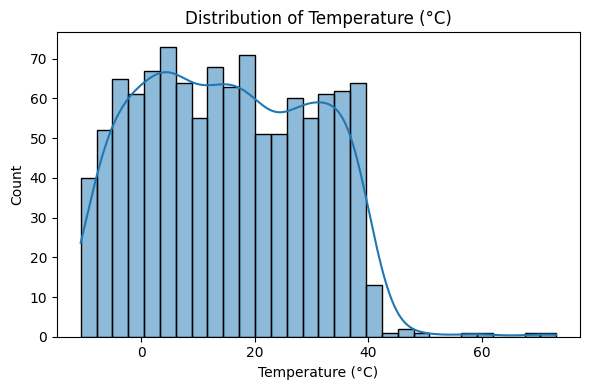

In [34]:
# List of important numerical features
features = ['Vehicle Age (years)', 'Energy Consumed (kWh)',
            'Distance Driven (since last charge) (km)',
            'Charging Duration (hours)', 'Charging Rate (kW)',
            'Temperature (°C)']

# Plot histograms for each feature
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_cleaned, x=feature, kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


The first three univariate distribution graphs provide valuable insights. Vehicle Age (years) shows a fairly uniform distribution from 0 to 7 years, followed by a sharp drop, indicating that most vehicles in the dataset are relatively new. This could make it harder for the model to learn about degraded batteries due to the limited number of older examples. Energy Consumed (kWh) displays a skewed distribution with most cases between 20 and 80 kWh, though some sessions exceed 140 kWh—possibly reflecting vehicles with larger batteries or more intensive use. These extreme values could distort the mean and should be reviewed as potential outliers. Distance Driven (since last charge) (km) has a slightly right-skewed distribution, with many short trips under 100 km but also a significant number between 150 and 300 km. This provides a useful range of real-world usage data to analyze battery performance. 📌 Overall interpretation: these variables show good dispersion and reflect realistic usage patterns, making them useful for predicting battery condition—though extreme values should be carefully considered.

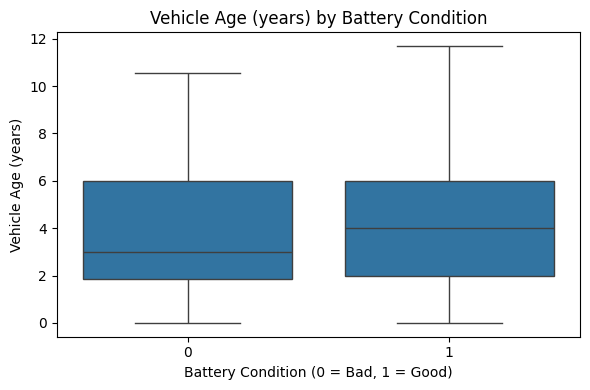

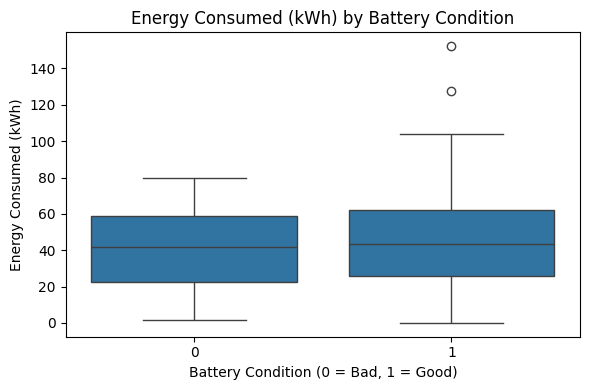

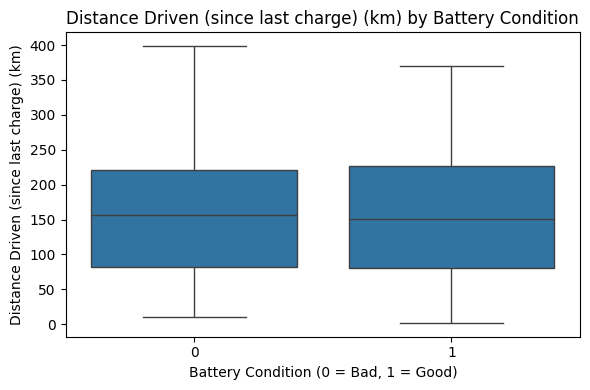

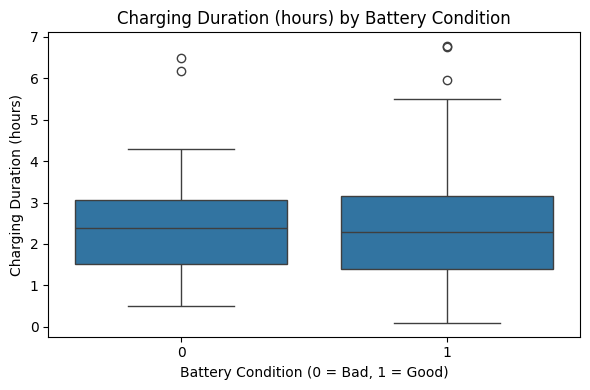

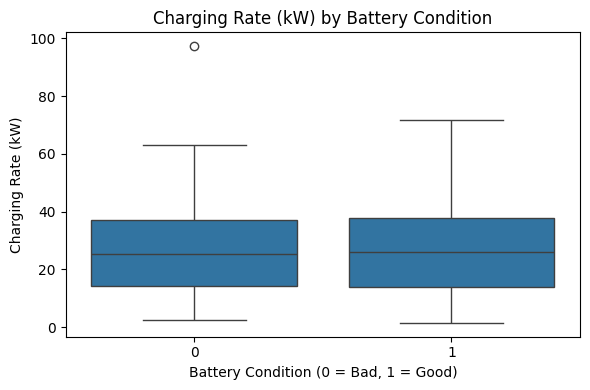

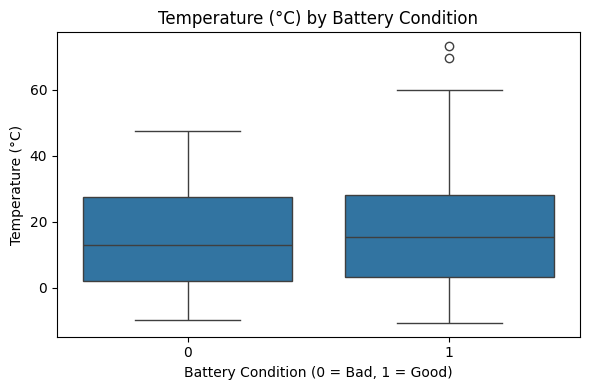

In [35]:
# Boxplots to compare distributions by battery condition
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_cleaned, x='Battery_Condition', y=feature)
    plt.title(f'{feature} by Battery Condition')
    plt.xlabel('Battery Condition (0 = Bad, 1 = Good)')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

✅ The last three boxplots (grouped by battery condition) reveal additional insights. Charging Duration (hours) tends to be slightly longer for healthy batteries (labeled as 1), which may reflect larger capacities or deeper charging sessions. While the difference isn’t drastic, it appears consistent. Charging Rate (kW) shows no clear distinction between good and bad batteries—the mean and spread are quite similar, suggesting this variable contributes little to the model on its own. Temperature (°C) also displays similar ranges for both groups, though healthy batteries seem to operate in a slightly broader range. While not conclusive, it’s still worth including to allow the model to explore potential interactions. 📌 Overall interpretation: Charging Duration may offer some predictive power regarding battery health. In contrast, Charging Rate and Temperature don’t show significant separation between classes individually, but they might reveal nonlinear patterns when combined with other variables.

# **Random Forest**

In [36]:
# Import machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Define feature columns
feature_cols = ['Vehicle Age (years)', 'Energy Consumed (kWh)',
                'Distance Driven (since last charge) (km)',
                'Charging Duration (hours)', 'Charging Rate (kW)',
                'Temperature (°C)']

# Split features and target
X = df_cleaned[feature_cols]
y = df_cleaned['Battery_Condition']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the model to disk
joblib.dump(model, 'battery_condition_model.pkl')

Confusion Matrix:
[[  3  71]
 [  5 253]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.04      0.07        74
           1       0.78      0.98      0.87       258

    accuracy                           0.77       332
   macro avg       0.58      0.51      0.47       332
weighted avg       0.69      0.77      0.69       332



['battery_condition_model.pkl']

The dataset is highly imbalanced, with significantly more samples labeled as "good battery" (class 1) than "bad battery" (class 0).
This imbalance causes the model to perform poorly on the minority class, as seen by the low recall and F1-score for class 0.
To address this, we will apply undersampling — a technique that randomly reduces the number of samples in the majority class
so that both classes have the same number of instances.
Although this approach reduces the total amount of training data, it helps prevent the model from becoming biased toward the majority class.
In this case, we will randomly sample from class 1 to match the number of instances in class 0, and then retrain the model on this balanced dataset.


In [37]:
# Split the dataset into two classes
df_class0 = df_cleaned[df_cleaned['Battery_Condition'] == 0]
df_class1 = df_cleaned[df_cleaned['Battery_Condition'] == 1]

# Undersample the majority class (class 1)
df_class1_sampled = df_class1.sample(n=len(df_class0), random_state=42)

# Combine both classes into a balanced dataset
df_balanced = pd.concat([df_class0, df_class1_sampled]).sample(frac=1, random_state=42)

# Redefine features and target
X_bal = df_balanced[feature_cols]
y_bal = df_balanced['Battery_Condition']

# Split again into train and test
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

# Train the model again
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[39 36]
 [36 38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52        75
           1       0.51      0.51      0.51        74

    accuracy                           0.52       149
   macro avg       0.52      0.52      0.52       149
weighted avg       0.52      0.52      0.52       149



Although we applied undersampling to balance the dataset and trained a Random Forest model, the results were not satisfactory. The model's performance remained close to random guessing, with both precision and recall around 0.5 for each class. This suggests that the features we selected may not be strong predictors of battery condition. Additionally, our method for labeling the battery condition — defining "bad" batteries as those below the 25th percentile of battery capacity — might not accurately reflect real-world degradation or failure. Battery health is likely influenced by more complex factors, such as usage history, number of charge cycles, or environmental stress, which may not be captured in the available features. Therefore, it may be necessary to rethink the classification criteria or even switch to a regression approach to model battery capacity as a continuous outcome.

In [40]:
# Import regression model and metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define target as continuous battery capacity
X = df_cleaned[feature_cols]
y = df_cleaned['Battery Capacity (kWh)']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Predict
y_pred = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 16.70
Root Mean Squared Error (RMSE): 20.46
R-squared (R²): -0.10


In [25]:
for col in df_cleaned.columns:
    print(f"'{col}'")

'User ID'
'Vehicle Model'
'Charging Station ID'
'Charging Station Location'
'Charging Start Time'
'Charging End Time'
'Energy Consumed (kWh)'
'Charging Duration (hours)'
'Charging Rate (kW)'
'Charging Cost (USD)'
'Time of Day'
'Day of Week'
'State of Charge (Start %)'
'State of Charge (End %)'
'Distance Driven (since last charge) (km)'
'Temperature (°C)'
'Vehicle Age (years)'
'Charger Type'
'User Type'
'Battery_Condition'


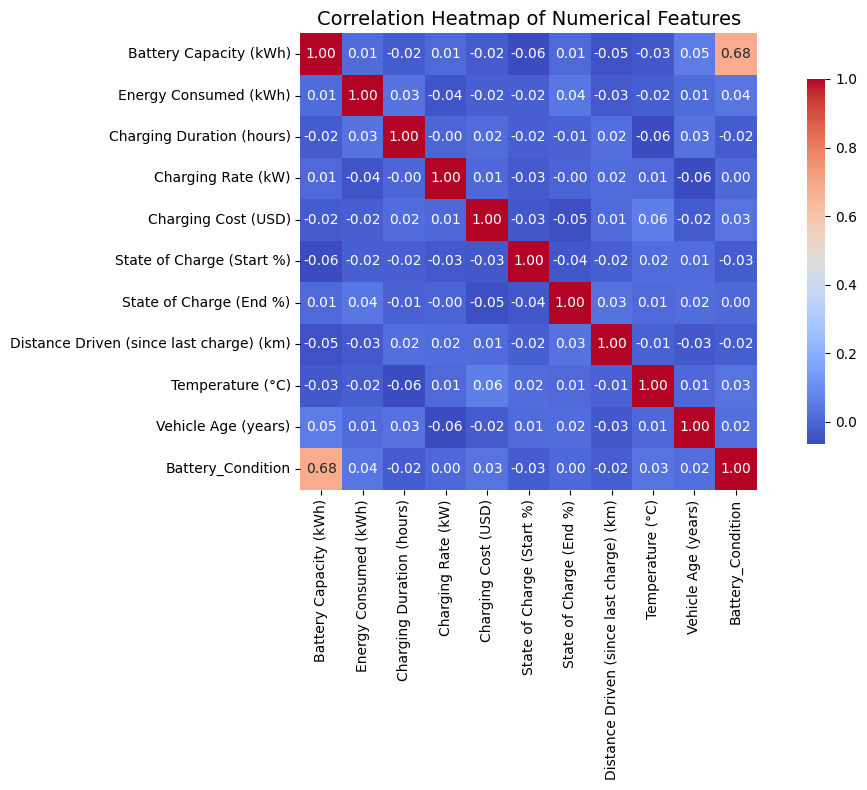

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure column names are clean
df_cleaned.columns = df_cleaned.columns.str.strip()

# Select only numerical columns
numeric_df = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

# **Summary**

The regression model failed to predict battery capacity accurately, as shown by a negative R² score and high error metrics. A correlation heatmap revealed that none of the numerical features had meaningful correlation with Battery Capacity (kWh). This indicates that the chosen features do not carry predictive power for battery size or health. Since battery capacity is typically determined by the vehicle model and design specifications, it's necessary to include categorical features such as Vehicle Model and User Type to capture this information. These features likely hold more explanatory value and will be one-hot encoded to improve the model's performance.

Updated code to prepare the new DataFrame

In [56]:
# Make a fresh copy of the cleaned DataFrame
df_model = df_cleaned.copy()

# Strip column names (remove leading/trailing spaces)
df_model.columns = df_model.columns.str.strip()

# One-hot encode categorical variables including Day of Week
df_model = pd.get_dummies(df_model, columns=['Vehicle Model', 'User Type', 'Time of Day', 'Day of Week', 'Charger Type'], drop_first=True)


# Define X and y
X = df_model.drop(columns=[
    'Battery Capacity (kWh)',  # target
    'Battery_Condition',       # binary label (not needed here)
    'User ID', 'Charging Station ID', 'Charging Station Location',
    'Charging Start Time', 'Charging End Time'  # non-numeric
])
y = df_model['Battery Capacity (kWh)']


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("🔁 Random Forest Results")
print("MAE:", round(mean_absolute_error(y_test, y_pred_rf), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_rf)), 2))
print("R²:", round(r2_score(y_test, y_pred_rf), 2))


🔁 Random Forest Results
MAE: 16.66
RMSE: 20.21
R²: -0.07


In [58]:
!pip install xgboost

In [59]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Crear y entrenar el modelo
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predicción
y_pred_xgb = xgb_model.predict(X_test)

# Evaluación
print("⚡ XGBoost Results")
print("MAE:", round(mean_absolute_error(y_test, y_pred_xgb), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 2))
print("R²:", round(r2_score(y_test, y_pred_xgb), 2))

⚡ XGBoost Results
MAE: 17.01
RMSE: 21.04
R²: -0.16


Several regression models were tested to predict battery capacity (kWh) using both numerical and categorical features from the dataset. The models included Random Forest Regressor and XGBoost Regressor, each trained on a version of the dataset with properly encoded categorical variables such as vehicle model, user type, time of day, day of the week, and charger type. Despite these efforts, both models yielded poor results, with negative R² scores and high error metrics (MAE and RMSE). These outcomes suggest that the available features do not contain sufficient predictive power to estimate battery capacity accurately, likely because this variable reflects a static specification of the vehicle rather than a dynamic measure of battery health or usage. As a result, alternative target variables or predictive goals should be considered for more meaningful modeling.